In [1]:
# Nonlinear MPC test using kinematic bicycle model for car
# We want to use the kinematic bicycle model from this paper (Figure 3)
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1#Tab4

# which has states:
# x, y = positional coordinates in inertial frame
# ψ = angle of car centerline in inertial frame
# ̇ψ = change of angle
# β = angle between car centerline and velocity vector
# ̇β = change of angle

# and has the equations:
# ̇x = v cos(ψ + β)
# ̇y = v sin(ψ + β)
# ̇v = a
# ̇ψ = v / lᵣ sin(β)
# β = arctan(lᵣ/(lf + lᵣ) tan(δf))
# ̇β = v/(lf + lᵣ) tan(δf) - v/lᵣ sin(β)
# ̇δf = ω

# and we want to solve it. Define the model:


The model has state and input:
\begin{gather*}
z = \begin{bmatrix}x\\ y\\ v\\ \psi\\ \beta\end{bmatrix},\quad
u = \begin{bmatrix}a\\ \delta_f\end{bmatrix},\quad
\end{gather*}
where the two control signals are $a$, the acceleration command, and $\delta_f$, the front steering angle (in radians).
The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
\\
\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}
\end{gather*}

## Casadi setup
From http://casadi.sourceforge.net/v3.4.4/users_guide/casadi-users_guide.pdf

In [2]:
import casadi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
from scipy               import interpolate
from scipy.optimize import curve_fit
from direct_collocation  import MpcProblem
from KinematicBicycleCar import KinematicBicycleCar

In [3]:
# road

road_center = np.array([
[2.519, 117.514],
[10.68, 117.192],
[22.303, 116.549],
[30.712, 115.585],
[40.357, 112.691],
[50.744, 107.226],
[50.249, 98.224],
[48.765, 84.721],
[47.529, 74.754],
[47.158, 64.466],
[47.034, 53.535],
[47.529, 41.318],
[48.024, 31.994],
[48.518, 22.028],
[58.41, 22.671],
[68.303, 23.635],
[77.453, 23.153],
])

road_width = np.array([
    6.0,
    6.0,
    5.95,
    5.9,
    5.84,
    5.80,
    5.80,
    5.86,
    5.82,
    5.78,
    5.72,
    5.7,
    5.68,
    5.6,
    5.52,
    5.44,
    5.40,
])

def fit(x, a, b, c):

    return a*np.square(x) + b*x + c

popt_y, pcov_y = curve_fit(fit, road_center[:,0], road_center[:,1])
x = np.linspace(road_center[0,0], road_center[-1,0],20)
y = fit(x, *popt_y)


In [4]:
car = KinematicBicycleCar(N=30, step=0.05)
        
ic = [0.0, 0.0, 5.5, np.pi/8, 0.0]
car.set_initial(ic)

# Cost
cost = (car.dae.x[0][2]-5)**2

In [12]:
    
mpcprob = MpcProblem(car,     # casadi.DaeBuilder()
                     cost,        # casadi symbolic objective
                    )
uk = [0.0,0.0]

n_runs = 80
x_plan = np.empty((mpcprob.model.n,n_runs+1))
u_plan = np.empty((mpcprob.model.m,n_runs))
x_true = np.empty((mpcprob.model.n,n_runs+1))
x_true[:,0] = ic
x_plan[:,0] = ic

boundary_up  = np.empty((n_runs,2))
boundary_low = np.empty((n_runs,2))


for k in range(n_runs):
    xk_opt, uk_opt = mpcprob.run(x_true[:,k])
    for i in range(5):
        x_plan[i,k+1] = xk_opt[i][1]
    for i in range(2):
        u_plan[i,k] = uk_opt[i][1]
    x_true[:,k+1] = mpcprob.simulate(x_true[:,k], u_plan[:,k])
    
    '''for k in range(n_runs):
        boundary_up[k,:] = mpcprob.model.upperbounds_x(k)[0:2]
        boundary_low[k,:] = mpcprob.model.lowerbounds_x(k)[0:2]
        plt.plot(boundary_up[:,0], boundary_up[:,1])
        plt.plot(boundary_low[:,0], boundary_low[:,1])
        print("\n\n",boundary_up, boundary_low, '\n\n')
    '''
    boundary_up[k,:] = mpcprob.model.upperbounds_x(0)[0:2]
    boundary_low[k,:] = mpcprob.model.lowerbounds_x(0)[0:2]
        
    
    # hack, test changing cost
    #if k > 10:
    #    mpcprob.set_cost(100*car.dae.x[0][2]**2)

#for k in range(1,n_runs):
    #print("True:", x_true[:,k])
    #print("Pred:", x_plan[:,k])
    #print("Error:", np.linalg.norm(x_true[:,k]-x_plan[:,k],2))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  49  1.5172083e+01 1.39e+01 1.07e+04  -1.0 5.70e+01    -  1.93e-02 6.35e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.4378314e+01 1.35e+01 1.14e+04  -1.0 1.97e+01    -  2.23e-04 2.37e-02f  1
  51  1.4372534e+01 1.35e+01 1.23e+04  -1.0 5.19e+01    -  1.38e-02 5.48e-04h  1
  52  1.4246216e+01 1.34e+01 1.19e+04  -1.0 3.97e+01    -  1.95e-04 6.48e-03f  1
  53  1.4243828e+01 1.34e+01 1.19e+04  -1.0 8.80e+01    -  1.95e-03 1.13e-03h  1
  54  1.3990968e+01 1.34e+01 1.18e+04  -1.0 2.10e+01    -  2.29e-03 5.22e-03h  1
  55  1.3986646e+01 1.33e+01 1.18e+04  -1.0 5.38e+01    -  5.11e-03 7.92e-04h  1
  56  1.3926620e+01 1.33e+01 1.18e+04  -1.0 1.44e+01    -  2.46e-04 2.02e-03f  1
  57  1.3875121e+01 1.29e+01 1.14e+04  -1.0 5.64e+01    -  3.13e-03 3.23e-02h  1
  58  1.3866104e+01 1.29e+01 1.14e+04  -1.0 3.39e+01    -  1.36e-03 2.60e-04h  1
  59  1.3876786e+01 1.29e+01 1.14e+04  -1.0 2.60e+02    -  4.62e-03 2.83e-04h  1
iter    objective    inf_pr 

 149  4.3484542e+00 2.56e-01 1.45e+04  -1.0 4.24e+00    -  2.41e-01 2.47e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  4.3484613e+00 2.56e-01 8.18e+04  -1.0 1.01e+01    -  1.50e-04 2.65e-05h  1
 151  4.3483689e+00 2.56e-01 5.58e+05  -1.0 7.85e+01    -  8.62e-05 1.44e-05h  1
 152r 4.3483689e+00 2.56e-01 9.99e+02  -0.6 0.00e+00    -  0.00e+00 9.40e-08R  2
 153r 4.3775209e+00 2.03e-01 1.00e+03  -0.6 3.15e+01    -  3.97e-04 5.87e-03f  1
 154  4.3775222e+00 2.03e-01 4.22e+04  -1.0 4.08e+00    -  1.73e-01 2.79e-06f  2
 155r 4.3775222e+00 2.03e-01 9.99e+02  -0.7 0.00e+00    -  0.00e+00 2.96e-07R  6
 156r 4.3848133e+00 1.85e-01 1.02e+03  -0.7 3.29e+01    -  7.16e-03 1.40e-03f  1
 157r 4.4165666e+00 1.16e-01 1.01e+03  -0.7 3.38e+01    -  5.41e-03 6.64e-03f  1
 158r 4.4165666e+00 1.16e-01 9.99e+02  -0.9 0.00e+00    -  0.00e+00 2.90e-07R  6
 159r 4.4173863e+00 1.15e-01 9.99e+02  -0.9 3.24e+01    -  2.06e-04 1.46e-04f  1
iter    objective    inf_pr 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  12  2.5028493e-01 1.53e-05 2.59e-02  -1.7 4.77e-01    -  1.00e+00 1.00e+00h  1
  13  6.4471675e-02 1.73e-04 1.30e+00  -3.8 2.99e+00    -  3.97e-01 1.00e+00f  1
  14  2.6393784e-02 7.07e-05 1.41e-01  -3.8 2.14e+00    -  9.03e-01 1.00e+00h  1
  15  1.7455015e-02 1.33e-04 1.66e-03  -3.8 1.43e+00    -  1.00e+00 1.00e+00h  1
  16  1.6761067e-02 3.28e-05 7.02e-05  -3.8 6.98e-01    -  1.00e+00 1.00e+00h  1
  17  1.6577321e-02 2.16e-08 5.01e-04  -5.7 5.01e-02  -2.0 1.00e+00 1.00e+00h  1
  18  1.6521747e-02 2.01e-09 6.24e-04  -5.7 2.34e-02  -1.6 1.00e+00 1.00e+00h  1
  19  1.6399274e-02 1.83e-08 2.99e-04  -5.7 2.03e+00    -  1.00e+00 8.11e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.6376552e-02 1.78e-06 2.07e-08  -5.7 7.06e-01    -  1.00e+00 1.00e+00f  1
  21  1.6371436e-02 9.73e-11 3.24e-07  -8.6 1.20e-02    -  9.99e-01 1.00e+00h  1
  22  1.6371427e-02 1.67e-14 9.72e-08  -8.6 1.09e-05  -2.1 1.00e+00 1.00e+00h  1
  23  1.6371427e-02 1.86e-14

  15  8.0256623e-04 5.13e-08 1.37e-04  -5.7 2.60e-01  -3.6 9.70e-01 1.00e+00h  1
  16  7.8058674e-04 8.87e-09 8.73e-05  -5.7 1.23e-01  -3.1 1.00e+00 1.00e+00h  1
  17  7.7958446e-04 6.18e-11 9.47e-05  -5.7 6.24e-03  -1.8 1.00e+00 1.00e+00h  1
  18  7.7670376e-04 4.18e-10 9.09e-05  -5.7 1.80e-02  -2.3 1.00e+00 1.00e+00h  1
  19  7.7565209e-04 5.14e-11 8.96e-05  -5.7 6.64e-03  -1.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  7.7263789e-04 3.30e-10 8.60e-05  -5.7 1.91e-02  -2.3 1.00e+00 1.00e+00h  1
  21  7.7153908e-04 4.46e-11 8.47e-05  -5.7 7.06e-03  -1.9 1.00e+00 1.00e+00h  1
  22  7.7113134e-04 6.17e-12 8.42e-05  -5.7 2.63e-03  -1.5 1.00e+00 1.00e+00h  1
  23  7.6993050e-04 5.28e-11 8.28e-05  -5.7 7.77e-03  -2.0 1.00e+00 1.00e+00h  1
  24  7.6948536e-04 7.28e-12 8.23e-05  -5.7 2.90e-03  -1.5 1.00e+00 1.00e+00h  1
  25  7.6817677e-04 6.16e-11 8.09e-05  -5.7 8.54e-03  -2.0 1.00e+00 1.00e+00h  1
  26  7.6447261e-04 4.67e-10

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  16  1.4601139e-03 1.18e-06 4.48e-04  -5.7 1.51e-01  -2.5 9.78e-01 1.00e+00h  1
  17  1.3364474e-03 5.67e-08 3.41e-04  -5.7 4.31e-02  -2.1 1.00e+00 1.00e+00h  1
  18  1.2055831e-03 7.17e-08 1.99e-04  -5.7 7.54e-02  -2.6 1.00e+00 1.00e+00h  1
  19  1.1455462e-03 1.16e-05 1.67e-04  -5.7 8.28e-01    -  1.00e+00 1.57e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0527076e-03 4.14e-04 1.44e-06  -5.7 6.98e-01    -  1.00e+00 1.00e+00f  1
  21  1.0515228e-03 1.93e-04 5.89e-08  -5.7 1.02e-01    -  1.00e+00 1.00e+00h  1
  22  1.0515178e-03 1.39e-06 1.75e-10  -5.7 7.62e-03    -  1.00e+00 1.00e+00h  1
  23  1.0496919e-03 4.74e-11 2.26e-08  -8.6 1.20e-02    -  9.99e-01 1.00e+00h  1
  24  1.0496780e-03 1.89e-11 5.46e-14  -9.0 1.22e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 24

                                   (scaled)                 (unscaled)
Objective...............:   1.0496780247350695e-03    1.0496780247350695e-03
Dual infeas

  14  1.1306317e-03 7.92e-06 2.42e-04  -5.7 6.96e-01    -  8.53e-01 1.00e+00h  1
  15  1.0574740e-03 1.00e-07 1.06e-05  -5.7 3.17e-01  -4.5 1.00e+00 1.00e+00h  1
  16  1.0428346e-03 7.94e-06 2.08e-09  -5.7 2.19e-01    -  1.00e+00 1.00e+00h  1
  17  1.0422328e-03 3.29e-10 1.85e-08  -8.6 1.40e-02    -  9.99e-01 1.00e+00h  1
  18  1.0422313e-03 4.24e-12 1.30e-13  -9.0 2.27e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............:   1.0422313274494669e-03    1.0422313274494669e-03
Dual infeasibility......:   1.2986539395655089e-13    1.2986539395655089e-13
Constraint violation....:   4.2437789393723335e-12    4.2437789393723335e-12
Complementarity.........:   9.1081880921062003e-10    9.1081880921062003e-10
Overall NLP error.......:   9.1081880921062003e-10    9.1081880921062003e-10


Number of objective function evaluations             = 19
Number of objective gradient evaluations        

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  14  1.9971519e-03 7.68e-07 5.38e-04  -3.8 5.38e-02  -2.0 1.00e+00 1.00e+00h  1
  15  1.7056230e-03 7.20e-07 3.44e-04  -5.7 1.03e-01  -2.5 9.85e-01 1.00e+00h  1
  16  1.5008345e-03 1.49e-07 2.36e-04  -5.7 2.12e-01  -3.0 1.00e+00 1.00e+00h  1
  17  1.0655511e-03 2.65e-06 1.19e-04  -5.7 3.00e+00    -  1.00e+00 4.84e-01h  1
  18  1.0825844e-03 1.64e-06 6.62e-05  -5.7 4.93e-01    -  1.00e+00 5.00e-01f  2
  19  1.0488657e-03 4.22e-07 2.53e-09  -5.7 2.44e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0418345e-03 8.34e-10 1.32e-07  -8.6 4.32e-02    -  9.93e-01 1.00e+00h  1
  21  1.0416581e-03 1.59e-11 2.73e-15  -8.6 1.21e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............:   1.0416580509139124e-03    1.0416580509139124e-03
Dual infeasibility......:   2.7299643571613423e-15    2.7299643571613423e-15
Constraint viol

  13  2.2960380e-03 3.86e-05 4.17e-03  -3.8 7.44e-01    -  8.61e-01 1.00e+00h  1
  14  1.2678311e-03 1.01e-05 1.94e-05  -3.8 7.90e-01    -  1.00e+00 1.00e+00h  1
  15  1.1255227e-03 4.38e-07 9.95e-05  -5.7 3.83e-01  -4.0 9.40e-01 1.00e+00h  1
  16  1.0417548e-03 1.10e-06 2.29e-06  -5.7 4.99e-01    -  1.00e+00 9.43e-01h  1
  17  1.0416774e-03 3.60e-10 9.31e-07  -8.6 2.81e-02  -4.5 9.96e-01 1.00e+00h  1
  18  1.0416598e-03 4.43e-07 2.27e-11  -8.6 2.91e-02    -  1.00e+00 1.00e+00h  1
  19  1.0416598e-03 4.77e-06 2.76e-10  -8.6 3.04e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0416598e-03 2.25e-09 2.63e-14  -8.6 3.28e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............:   1.0416598196588626e-03    1.0416598196588626e-03
Dual infeasibility......:   2.6251460676153436e-14    2.6251460676153436e-14
Constraint viol

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   1  3.7272868e+01 3.13e+01 1.21e+00  -1.0 5.92e+01    -  2.06e-03 4.57e-03h  1
   2  3.7252270e+01 3.13e+01 1.46e+01  -1.0 1.41e+01    -  3.83e-03 3.74e-04f  1
   3  2.7357419e+01 2.57e+01 3.30e+03  -1.0 2.75e+01    -  3.12e-03 1.80e-01f  1
   4  1.5853903e+01 1.78e+01 2.35e+03  -1.0 5.87e+00    -  1.49e-02 3.07e-01f  1
   5  1.5728037e+01 1.77e+01 2.33e+03  -1.0 2.19e+01   0.0 6.16e-02 5.77e-03h  1
   6  1.5636802e+01 1.76e+01 2.32e+03  -1.0 6.41e+01  -0.5 1.96e-02 4.31e-03h  1
   7  1.5486400e+01 1.75e+01 2.31e+03  -1.0 5.87e+01    -  1.91e-02 7.06e-03h  1
   8  1.3928317e+01 1.62e+01 2.14e+03  -1.0 6.66e+00    -  1.40e-01 7.35e-02f  1
   9  1.1924509e+01 1.44e+01 1.93e+03  -1.0 2.70e+00    -  3.25e-01 1.09e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.8002288e+00 9.10e+00 1.23e+03  -1.0 2.41e+00    -  5.53e-01 3.70e-01f  1
  11  1.4824292e+00 9.96e-03 1.17e+01  -1.0 1.62e+00    -  4.54e-01 1.00e+00f  1
  12  9.2180238e-01 1.26e-03

   8  1.3315791e+01 1.57e+01 1.26e+03  -1.0 1.41e+01    -  8.69e-02 1.82e-02h  1
   9  1.0885341e+01 1.35e+01 1.21e+03  -1.0 3.25e+00    -  2.70e-01 1.42e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.2986840e+00 8.42e+00 9.29e+02  -1.0 2.48e+00    -  5.99e-01 3.74e-01f  1
  11  1.5804654e+00 8.89e-03 1.01e+02  -1.0 1.42e+00    -  6.61e-01 1.00e+00f  1
  12  1.5496390e+00 1.12e-02 2.14e+01  -1.0 1.07e+00    -  7.87e-01 6.93e-01f  1
  13  1.6161248e+00 1.59e-02 1.47e+01  -1.0 2.13e+00    -  2.80e-01 1.00e+00f  1
  14  1.3729414e+00 1.70e-02 8.35e+00  -1.0 1.52e+00    -  2.53e-01 7.65e-01f  1
  15  6.1459273e-01 2.74e-02 1.72e+00  -1.0 8.63e-01    -  3.28e-01 1.00e+00f  1
  16  2.9641523e-01 2.10e-02 6.37e-01  -1.0 1.40e+00    -  7.55e-01 6.19e-01f  1
  17  1.3423513e-01 3.59e-03 2.66e-01  -1.7 3.26e-01    -  5.08e-01 1.00e+00f  1
  18  1.3074148e-01 6.42e-03 1.52e-01  -1.7 7.10e+00    -  7.05e-01 4.63e-02h  3
  19  5.1165527e-02 5.09e-05

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   3  2.7365424e+01 2.57e+01 3.30e+03  -1.0 2.75e+01    -  3.13e-03 1.80e-01f  1
   4  1.8186505e+01 1.96e+01 2.56e+03  -1.0 5.87e+00    -  1.50e-02 2.38e-01f  1
   5  1.7921221e+01 1.94e+01 2.53e+03  -1.0 1.97e+01   0.0 6.47e-02 1.01e-02h  1
   6  1.6121557e+01 1.80e+01 2.36e+03  -1.0 5.22e+00    -  1.84e-01 7.09e-02f  1
   7  1.2426271e+01 1.49e+01 1.98e+03  -1.0 3.00e+00    -  4.01e-01 1.71e-01f  1
   8  6.0436014e+00 8.13e+00 1.08e+03  -1.0 2.62e+00    -  4.32e-01 4.55e-01f  1
   9  1.4258333e+00 9.98e-03 1.29e+01  -1.0 1.36e+00    -  4.52e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.9185391e-01 4.28e-03 1.47e+01  -1.0 5.36e-01    -  2.69e-01 1.00e+00f  1
  11  4.6975303e-01 1.60e-03 5.78e+00  -1.0 6.29e-01    -  5.92e-01 1.00e+00f  1
  12  1.6676296e-01 2.16e-03 1.18e+00  -1.0 1.07e+00    -  7.56e-01 1.00e+00f  1
  13  8.1135878e-02 1.03e-02 1.08e+00  -1.0 1.24e+00    -  1.00e+00 1.00e+00f  1
  14  7.2160926e-02 2.22e-03

   5  1.8085485e+01 1.95e+01 2.54e+03  -1.0 1.85e+01   0.0 6.84e-02 1.09e-02h  1
   6  1.6164141e+01 1.80e+01 2.36e+03  -1.0 5.03e+00    -  1.89e-01 7.49e-02f  1
   7  1.2420786e+01 1.49e+01 1.97e+03  -1.0 3.00e+00    -  4.07e-01 1.73e-01f  1
   8  6.0147401e+00 8.10e+00 1.07e+03  -1.0 2.74e+00    -  4.28e-01 4.57e-01f  1
   9  1.4119225e+00 1.10e-02 1.34e+01  -1.0 1.36e+00    -  4.49e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.9192164e-01 8.68e-03 1.49e+01  -1.0 5.70e-01    -  2.69e-01 9.72e-01f  1
  11  4.6317214e-01 6.70e-03 6.05e+00  -1.0 6.36e-01    -  5.85e-01 1.00e+00f  1
  12  1.6487016e-01 5.07e-03 1.24e+00  -1.0 1.06e+00    -  7.60e-01 1.00e+00f  1
  13  8.3629476e-02 9.96e-03 9.38e-01  -1.0 1.24e+00    -  8.67e-01 1.00e+00f  1
  14  5.6880509e-02 7.94e-04 7.54e-02  -1.7 1.37e-01    -  9.36e-01 1.00e+00h  1
  15  2.6911284e-02 1.07e-03 1.73e-03  -2.5 3.57e-01    -  1.00e+00 1.00e+00h  1
  16  2.5693091e-02 1.14e-07

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  45  1.0416591e-03 3.38e-14 1.42e-10  -8.6 7.98e-07  -3.7 1.00e+00 1.00e+00h  1

Number of Iterations....: 45

                                   (scaled)                 (unscaled)
Objective...............:   1.0416590818514663e-03    1.0416590818514663e-03
Dual infeasibility......:   1.4227811902641250e-10    1.4227811902641250e-10
Constraint violation....:   3.3834046675451646e-14    3.3834046675451646e-14
Complementarity.........:   2.5059035596800692e-09    2.5059035596800692e-09
Overall NLP error.......:   2.5059035596800692e-09    2.5059035596800692e-09


Number of objective function evaluations             = 46
Number of objective gradient evaluations             = 46
Number of equality constraint evaluations            = 46
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 46
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 45
Total CPU secs in IPOPT (w

  33  1.0416640e-03 4.16e-13 5.65e-10  -8.6 4.69e-06  -3.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 33

                                   (scaled)                 (unscaled)
Objective...............:   1.0416640052187565e-03    1.0416640052187565e-03
Dual infeasibility......:   5.6473185642732420e-10    5.6473185642732420e-10
Constraint violation....:   4.1646373849513196e-13    4.1646373849513196e-13
Complementarity.........:   2.5059035630000248e-09    2.5059035630000248e-09
Overall NLP error.......:   2.5059035630000248e-09    2.5059035630000248e-09


Number of objective function evaluations             = 34
Number of objective gradient evaluations             = 34
Number of equality constraint evaluations            = 34
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 34
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 33
Total CPU secs in IPOPT (w

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.7350150e+01 3.14e+01 1.48e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  3.7272905e+01 3.13e+01 1.21e+00  -1.0 5.92e+01    -  2.06e-03 4.58e-03h  1
   2  3.7252329e+01 3.13e+01 1.46e+01  -1.0 1.41e+01    -  3.84e-03 3.74e-04f  1
   3  2.7367140e+01 2.57e+01 3.30e+03  -1.0 2.75e+01    -  3.13e-03 1.80e-01f  1
   4  1.5318393e+0

  14  1.4609884e-03 4.65e-08 3.43e-04  -5.7 3.43e-02  -2.0 1.00e+00 1.00e+00h  1
  15  1.3699947e-03 4.07e-08 2.07e-04  -5.7 6.22e-02  -2.5 1.00e+00 1.00e+00h  1
  16  1.3503996e-03 2.14e-09 1.76e-04  -5.7 1.98e-02  -2.1 1.00e+00 1.00e+00h  1
  17  1.0730965e-03 1.87e-05 1.07e-04  -5.7 2.61e+00    -  1.00e+00 3.91e-01f  1
  18  1.0940346e-03 2.04e-05 2.30e-07  -5.7 5.48e-01    -  1.00e+00 1.00e+00f  1
  19  1.0493376e-03 5.47e-06 1.85e-09  -5.7 2.47e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0418633e-03 1.46e-09 4.34e-08  -8.6 4.63e-02    -  9.92e-01 1.00e+00h  1
  21  1.0416610e-03 1.14e-11 5.95e-15  -8.6 1.38e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............:   1.0416609661273244e-03    1.0416609661273244e-03
Dual infeasibility......:   5.9471996654781327e-15    5.9471996654781327e-15
Constraint viol

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0717430e-01 1.10e-04 8.55e-03  -2.5 7.59e-01    -  8.40e-01 1.00e+00f  1
  11  1.8943870e-02 1.11e-04 4.06e-03  -3.8 2.31e+00    -  6.69e-01 1.00e+00f  1
  12  2.6015864e-03 3.49e-05 4.18e-04  -3.8 1.64e+00    -  9.30e-01 1.00e+00h  1
  13  2.0190366e-03 3.41e-07 6.78e-04  -5.7 6.86e-02  -2.0 9.71e-01 1.00e+00h  1
  14  1.6267095e-03 3.28e-07 3.69e-04  -5.7 1.11e-01  -2.5 1.00e+00 1.00e+00h  1
  15  1.5609347e-03 1.54e-08 2.91e-04  -5.7 3.27e-02  -2.1 1.00e+00 1.00e+00h  1
  16  1.4579601e-03 3.30e-08 1.97e-04  -5.7 6.65e-02  -2.5 1.00e+00 1.00e+00h  1
  17  1.1094769e-03 3.11e-05 1.19e-04  -5.7 2.73e+00    -  1.00e+00 3.96e-01h  1
  18  1.0960377e-03 9.22e-06 4.29e-08  -5.7 8.41e-01    -  1.00e+00 1.00e+00f  1
  19  1.0497202e-03 1.27e-07 4.05e-11  -5.7 2.55e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0418812e-03 8.87e-10

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.3580823e-01 3.88e-03 3.66e+00  -1.0 6.10e-01    -  5.97e-01 1.00e+00f  1
  11  1.6838001e-01 2.91e-03 6.23e-01  -1.0 1.14e+00    -  9.96e-01 1.00e+00f  1
  12  9.0459600e-02 6.87e-04 1.05e-01  -1.7 9.11e-01    -  1.00e+00 1.00e+00h  1
  13  3.0850044e-02 1.53e-04 7.28e-03  -2.5 6.49e-01    -  9.29e-01 1.00e+00h  1
  14  4.3500335e-03 1.81e-04 4.96e-03  -3.8 1.27e+00    -  7.86e-01 1.00e+00h  1
  15  1.4723150e-03 3.64e-04 1.70e-04  -3.8 8.51e-01    -  1.00e+00 1.00e+00h  1
  16  1.4684867e-03 3.89e-08 5.26e-04  -5.7 1.58e-03  -0.5 1.00e+00 1.00e+00h  1
  17  1.4618669e-03 7.06e-10 2.82e-04  -5.7 2.53e-03  -1.0 1.00e+00 1.00e+00h  1
  18  1.4473832e-03 4.33e-09 2.56e-04  -5.7 6.92e-03  -1.4 1.00e+00 1.00e+00h  1
  19  1.4232208e-03 1.78e-08 2.10e-04  -5.7 1.70e-02  -1.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.3855085e-03 5.11e-08

  44  1.0416642e-03 7.07e-14 8.28e-09  -9.0 1.38e-05  -3.2 1.00e+00 1.00e+00h  1

Number of Iterations....: 44

                                   (scaled)                 (unscaled)
Objective...............:   1.0416642030032291e-03    1.0416642030032291e-03
Dual infeasibility......:   8.2810513188419696e-09    8.2810513188419696e-09
Constraint violation....:   7.0721206668622472e-14    7.0721206668622472e-14
Complementarity.........:   9.0909090909091127e-10    9.0909090909091127e-10
Overall NLP error.......:   8.2810513188419696e-09    8.2810513188419696e-09


Number of objective function evaluations             = 47
Number of objective gradient evaluations             = 45
Number of equality constraint evaluations            = 47
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 45
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 44
Total CPU secs in IPOPT (w

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      660

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  33  1.0456980e-03 1.39e-09 2.93e-05  -5.7 4.81e-03  -2.2 1.00e+00 1.00e+00h  1
  34  1.0454870e-03 1.91e-10 2.57e-05  -5.7 1.58e-03  -1.8 1.00e+00 1.00e+00h  1
  35  1.0451766e-03 1.78e-09 2.07e-05  -5.7 3.82e-03  -2.3 1.00e+00 1.00e+00h  1
  36  1.0434034e-03 2.64e-04 8.34e-08  -5.7 2.04e-01    -  1.00e+00 1.00e+00h  1
  37  1.0434413e-03 1.82e-05 1.56e-09  -5.7 2.72e-02    -  1.00e+00 1.00e+00h  1
  38  1.0416159e-03 1.21e-10 1.97e-08  -8.6 1.23e-02    -  9.99e-01 1.00e+00h  1
  39  1.0416018e-03 8.71e-10 2.46e-11  -9.0 1.94e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 39

                                   (scaled)                 (unscaled)
Objective...............:   1.0416017625983660e-03    1.0416017625983660e-03
Dual infeasibility......:   2.4601863866291102e-11    2.4601863866291102e-11
Constraint violation....:   8.7120214384631134e-10    8.7120214384631134e-10
Complementarity.........:   9.1073277256756702e-10    9.1073277256756702e-10
Overall NLP error......

  34  1.0416559e-03 8.66e-14 8.34e-09  -8.6 1.35e-05  -3.2 1.00e+00 1.00e+00h  1

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:   1.0416559179200376e-03    1.0416559179200376e-03
Dual infeasibility......:   8.3355053963783209e-09    8.3355053963783209e-09
Constraint violation....:   8.6597395920762210e-14    8.6597395920762210e-14
Complementarity.........:   2.5059035596800696e-09    2.5059035596800696e-09
Overall NLP error.......:   8.3355053963783209e-09    8.3355053963783209e-09


Number of objective function evaluations             = 35
Number of objective gradient evaluations             = 35
Number of equality constraint evaluations            = 35
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 35
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 34
Total CPU secs in IPOPT (w

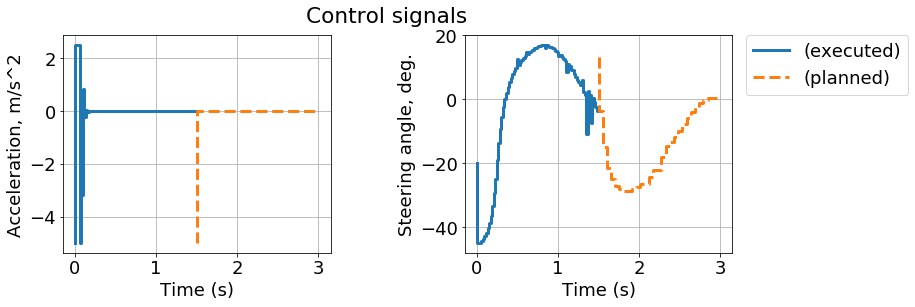

In [21]:
u_plt, u_ax1, u_ax2 = car.plot_u(u_plan, mpcprob.u_opt)
# control limits

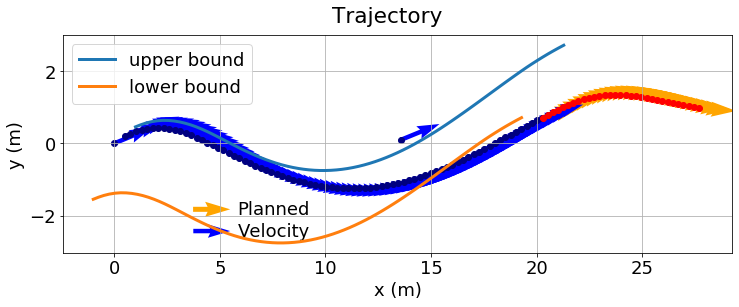

In [22]:
x_plt, x_ax = car.plot_x(x_plan, mpcprob.x_opt)

plt.plot(boundary_up[:,0], boundary_up[:,1], label="upper bound")
plt.plot(boundary_low[:,0], boundary_low[:,1], label="lower bound")
plt.legend()
plt.show()

In [14]:
print("Final state:")
print("(x,y):", x_plan[0,-1], x_plan[1,-1])
print("v    :", x_plan[2])

Final state:
(x,y): 20.53237419958582 0.7858322773614548
v    : [5.5        5.625      5.37500078 5.50000078 5.62500078 5.37500082
 5.12500113 4.9667545  5.00890672 4.99761355 5.00063895 4.99982916
 5.00004531 4.99998821 5.00000307 4.9999987  5.00000072 4.99999973
 5.         4.99999985 4.99999996 4.9999999  4.99999955 5.00000047
 4.99999939 4.99999639 5.00000093 4.99999725 4.99999817 4.99999535
 4.99999735 5.00000066 4.99999512 5.00000117 4.99999916 5.00000038
 4.99999985 4.99999999 4.99999995 4.99999996 5.00000034 4.99999711
 5.00000116 4.99999916 5.00000048 4.99999979 4.99999992 5.00000019
 4.99999942 5.0000001  4.99999992 4.99999997 4.99999996 4.99999996
 5.00000035 4.99999978 4.99999997 4.9999999  4.99999989 4.99999993
 4.99999984 5.00000009 4.99999942 5.00000012 4.99999994 4.99999998
 5.00000038 4.99999983 5.00000003 4.99999985 4.99999947 5.00000056
 4.99999931 5.00000015 5.00000008 4.99999995 4.99999631 5.00000493
 4.99999495 5.00000132 4.99999954]


In [18]:
for i in range(np.size(x_plan)//5):
    print(x_plan[0,i], x_plan[1,i], x_plan[2,i])
'''
road = np.transpose(np.vstack([np.array([ -2.11597999,   4.19037355,   8.88374513 , -3.80202949, -16.7563257 ]),
                 np.array([117.52194768, 117.60301031, 118.33077488, 119.53519875, 118.52077657])]))
print(road, np.shape(road))
road_sorted = road[road[:,0].argsort()]
print(road_sorted)
road_spline  = interpolate.splrep(road_sorted[:,0], road_sorted[:,1])

x = road[:,0]
plt.scatter(road[:,0], road[:,1])
plt.plot(x, interpolate.splev(x, road_spline))

# A lot of stuff seems to be broken in the road computations.
'''

0.0 0.0 5.5
13.58304147604903 0.09888452953707395 5.625000001070727
0.49931839440359393 0.18998105325537454 5.375000777283009
0.7599540871880549 0.26721447955669353 5.500000777202821
1.0306892397926513 0.330728607285293 5.625000777232645
1.3015568040669383 0.37800656338337474 5.375000822277547
1.5621968601866072 0.40893002041139415 5.125001128376048
1.818472979379213 0.42610148212969073 4.966754499895341
2.0824005067333755 0.43061205375247663 5.008906718348261
2.344337947855385 0.42243749211109993 4.997613548614637
2.606133671071716 0.4022453996341571 5.00063894687536
2.866689923770581 0.3708918126929039 4.999829156655486
3.125860370768839 0.3294130909615922 5.0000453059783405
3.383456453701278 0.27912431220758627 4.999988212991051
3.639518112478182 0.22151717066875978 5.000003072070787
3.894238987792553 0.1582330213633947 4.999998703453194
4.1479266559517365 0.09090164485392654 5.000000715448203
4.400860609188686 0.02076429523111882 4.999999730096031
4.653298814215395 -0.0511647476068

'\nroad = np.transpose(np.vstack([np.array([ -2.11597999,   4.19037355,   8.88374513 , -3.80202949, -16.7563257 ]),\n                 np.array([117.52194768, 117.60301031, 118.33077488, 119.53519875, 118.52077657])]))\nprint(road, np.shape(road))\nroad_sorted = road[road[:,0].argsort()]\nprint(road_sorted)\nroad_spline  = interpolate.splrep(road_sorted[:,0], road_sorted[:,1])\n\nx = road[:,0]\nplt.scatter(road[:,0], road[:,1])\nplt.plot(x, interpolate.splev(x, road_spline))\n\n# A lot of stuff seems to be broken in the road computations.\n'

In [9]:
# This is the road to my parents' house, distances in meters.
'''
road_left = np.array([
[2.519, 117.514],
[10.68, 117.192],
[22.303, 116.549],
[30.712, 115.585],
[40.357, 112.691],
[50.744, 107.226],
[50.249, 98.224],
[48.765, 84.721],
[47.529, 74.754],
[47.158, 64.466],
[47.034, 53.535],
[47.529, 41.318],
[48.024, 31.994],
[48.518, 22.028],
[58.41, 22.671],
[68.303, 23.635],
[77.453, 23.153],
])

road_right = np.array([
[2.519, 109.155],
[10.68, 109.316],
[22.427, 108.19],
[30.094, 107.708],
[38.626, 105.297],
[42.83, 102.403],
[43.325, 98.545],
[42.583, 86.007],
[41.222, 75.719],
[40.852, 65.431],
[40.357, 53.856],
[40.852, 41.318],
[41.346, 30.869],
[45.179, 14.955],
[57.916, 14.312],
[68.056, 15.276],
[77.206, 14.312],
])
'''

'\nroad_left = np.array([\n[2.519, 117.514],\n[10.68, 117.192],\n[22.303, 116.549],\n[30.712, 115.585],\n[40.357, 112.691],\n[50.744, 107.226],\n[50.249, 98.224],\n[48.765, 84.721],\n[47.529, 74.754],\n[47.158, 64.466],\n[47.034, 53.535],\n[47.529, 41.318],\n[48.024, 31.994],\n[48.518, 22.028],\n[58.41, 22.671],\n[68.303, 23.635],\n[77.453, 23.153],\n])\n\nroad_right = np.array([\n[2.519, 109.155],\n[10.68, 109.316],\n[22.427, 108.19],\n[30.094, 107.708],\n[38.626, 105.297],\n[42.83, 102.403],\n[43.325, 98.545],\n[42.583, 86.007],\n[41.222, 75.719],\n[40.852, 65.431],\n[40.357, 53.856],\n[40.852, 41.318],\n[41.346, 30.869],\n[45.179, 14.955],\n[57.916, 14.312],\n[68.056, 15.276],\n[77.206, 14.312],\n])\n'